In [1]:
pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 20.6 MB/s eta 0:00:00


In [2]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import argparse
from pydub import AudioSegment
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from itertools import groupby

In [4]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [5]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
folder_female = os.path.join('drive', 'MyDrive', 'data_course_work', 'female')
folder_male = os.path.join('drive', 'MyDrive', 'data_course_work', 'male')
formats_to_convert = ['.m4a']

for (dirpath, dirnames, filenames) in os.walk(folder_female):
    for filename in filenames:
        if filename.endswith(tuple(formats_to_convert)):

            filepath = dirpath + '/' + filename
            (path, file_extension) = os.path.splitext(filepath)
            file_extension_final = file_extension.replace('.', '')
            try:
                track = AudioSegment.from_file(filepath,
                        file_extension_final)
                wav_filename = filename.replace(file_extension_final, 'wav')
                wav_path = dirpath + '/' + wav_filename
                print('CONVERTING: ' + str(filepath))
                file_handle = track.export(wav_path, format='wav')
                os.remove(filepath)
            except:
                print("ERROR CONVERTING " + str(filepath))


for (dirpath, dirnames, filenames) in os.walk(folder_male):
    for filename in filenames:
        if filename.endswith(tuple(formats_to_convert)):

            filepath = dirpath + '/' + filename
            (path, file_extension) = os.path.splitext(filepath)
            file_extension_final = file_extension.replace('.', '')
            try:
                track = AudioSegment.from_file(filepath,
                        file_extension_final)
                wav_filename = filename.replace(file_extension_final, 'wav')
                wav_path = dirpath + '/' + wav_filename
                print('CONVERTING: ' + str(filepath))
                file_handle = track.export(wav_path, format='wav')
                os.remove(filepath)
            except:
                print("ERROR CONVERTING " + str(filepath))

CONVERTING: drive/MyDrive/data_course_work/female/0.m4a
CONVERTING: drive/MyDrive/data_course_work/female/4.m4a
CONVERTING: drive/MyDrive/data_course_work/female/1.m4a
CONVERTING: drive/MyDrive/data_course_work/female/3.m4a
CONVERTING: drive/MyDrive/data_course_work/female/5.m4a
CONVERTING: drive/MyDrive/data_course_work/female/2.m4a
CONVERTING: drive/MyDrive/data_course_work/female/21.m4a
CONVERTING: drive/MyDrive/data_course_work/female/15.m4a
CONVERTING: drive/MyDrive/data_course_work/female/10.m4a
CONVERTING: drive/MyDrive/data_course_work/female/16.m4a
CONVERTING: drive/MyDrive/data_course_work/female/12.m4a
CONVERTING: drive/MyDrive/data_course_work/female/13.m4a
CONVERTING: drive/MyDrive/data_course_work/female/7.m4a
CONVERTING: drive/MyDrive/data_course_work/female/17.m4a
CONVERTING: drive/MyDrive/data_course_work/female/14.m4a
CONVERTING: drive/MyDrive/data_course_work/female/9.m4a
CONVERTING: drive/MyDrive/data_course_work/female/22.m4a
CONVERTING: drive/MyDrive/data_course_w

In [ ]:

test = os.listdir(folder_female)

for item in test:
    if item.endswith(".m4a"):
        os.remove(os.path.join(folder_female, item))

test = os.listdir(folder_male)

for item in test:
    if item.endswith(".m4a"):
        os.remove(os.path.join(folder_male, item))

In [6]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([64000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [8]:
female = os.path.join('drive', 'MyDrive', 'data_course_work', 'female', '0.wav')
male = os.path.join('drive', 'MyDrive', 'data_course_work', 'male', '0.wav')

In [9]:
female_wave = load_wav_16k_mono(female)
male_wave = load_wav_16k_mono(male)

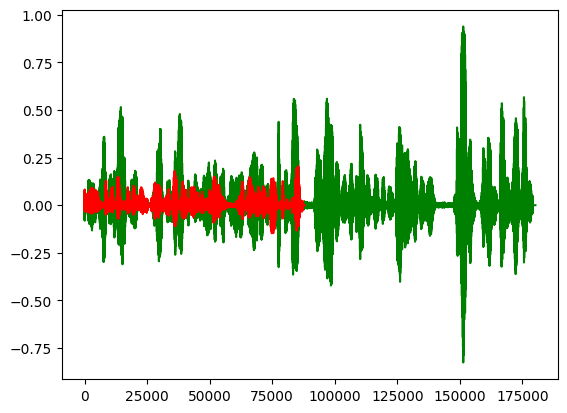

In [ ]:
plt.plot(female_wave, color='g')
plt.plot(male_wave, color='r')
plt.show()

In [10]:
female_clips = os.path.join('drive', 'MyDrive', 'data_course_work', 'female')
male_clips = os.path.join('drive', 'MyDrive', 'data_course_work', 'male')

In [11]:
POS = tf.data.Dataset.list_files(female_clips+'/*.wav')
NEG = tf.data.Dataset.list_files(male_clips+'/*.wav')

In [12]:
positives = tf.data.Dataset.zip((POS, tf.data.Dataset.from_tensor_slices(tf.ones(len(POS)))))
negatives = tf.data.Dataset.zip((NEG, tf.data.Dataset.from_tensor_slices(tf.zeros(len(NEG)))))
data = positives.concatenate(negatives)

In [ ]:
lens = []
for file in os.listdir(os.path.join('drive', 'MyDrive', 'data_course_work', 'female')):
    tensor_wave = load_wav_16k_mono(os.path.join('drive', 'MyDrive', 'data_course_work', 'male', file))
    lens.append(len(tensor_wave))

In [ ]:
tf.math.reduce_mean(lens)

<tf.Tensor: shape=(), dtype=int32, numpy=110821>

In [ ]:
tf.math.reduce_min(lens)

<tf.Tensor: shape=(), dtype=int32, numpy=63488>

In [ ]:
tf.math.reduce_max(lens)

<tf.Tensor: shape=(), dtype=int32, numpy=628736>

In [13]:
filepath, label = positives.shuffle(buffer_size=1000).as_numpy_iterator().next()

In [14]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:64000]
    zero_padding = tf.zeros([64000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [15]:
spectrogram, label = preprocess(filepath, label)

In [ ]:
label

1.0

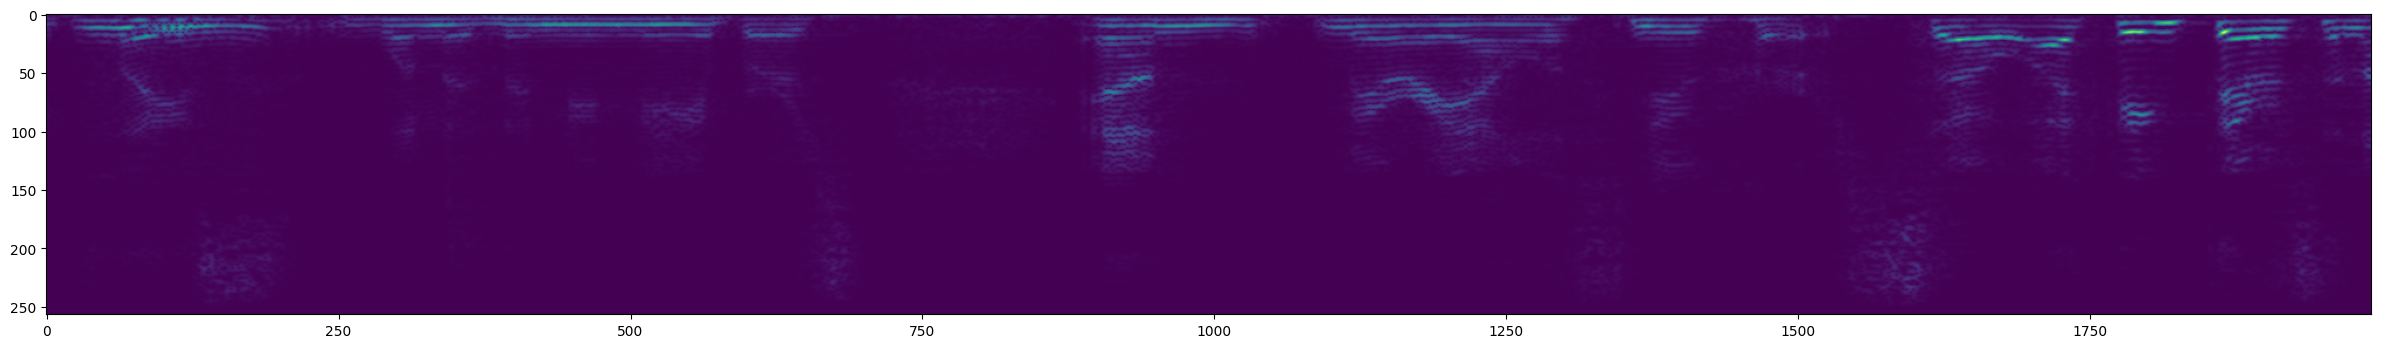

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [16]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(8)
data = data.prefetch(8)

In [ ]:
len(data) * 0.3


37.8

In [17]:
train = data.take(88)
test = data.skip(88).take(38)

In [18]:
samples, labels = train.as_numpy_iterator().next()

KeyboardInterrupt: ignored

In [ ]:
samples.shape

(8, 1991, 257, 1)

In [18]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(1991, 257,1)))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [19]:
model.compile('adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Precision()])


In [ ]:
model.summary()

In [24]:
hist = model.fit_generator(train, epochs=3, validation_data=test)

Epoch 1/3
 1/88 [..............................] - ETA: 12s - loss: 0.1053 - precision: 1.0000

<ipython-input-24-0472537c82c1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train, epochs=3, validation_data=test)


88/88 [==============================] - 10s 116ms/step - loss: 0.2128 - precision: 0.9144 - val_loss: 0.1201 - val_precision: 0.9790
Epoch 2/3
88/88 [==============================] - 10s 117ms/step - loss: 0.1418 - precision: 0.9428 - val_loss: 0.1043 - val_precision: 0.9797
Epoch 3/3
88/88 [==============================] - 10s 115ms/step - loss: 0.0855 - precision: 0.9643 - val_loss: 0.0556 - val_precision: 0.9662


In [25]:
model.save('drive/MyDrive/curs_work_model_f_m.model')

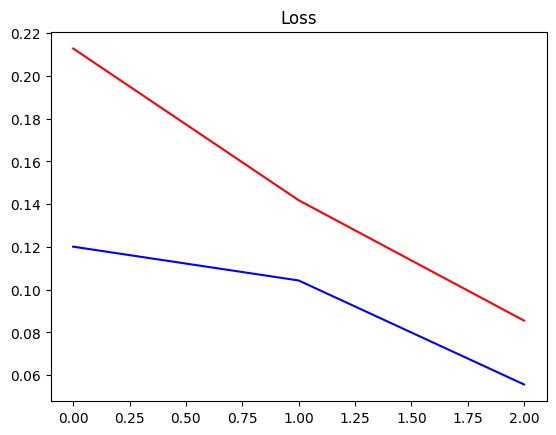

In [26]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

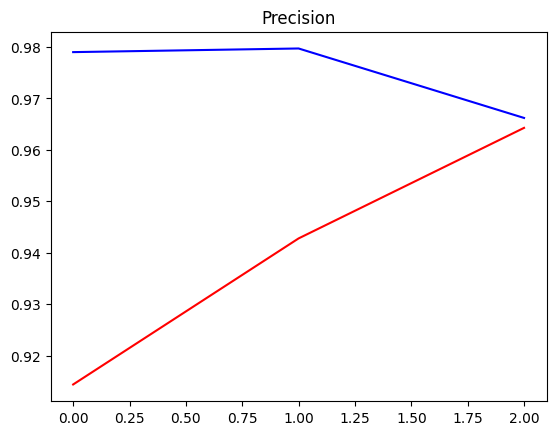

In [27]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [31]:
X_test, y_test = test.as_numpy_iterator().next()

In [32]:
y_test

array([1., 1., 0., 0., 1., 0., 0., 1.], dtype=float32)

In [28]:
from tensorflow.keras import models

In [29]:
loaded_model = models.load_model('drive/MyDrive/curs_work_model_f_m.model')

In [33]:
yhat = loaded_model.predict(X_test)

1/1 [==============================] - 0s 423ms/step


In [34]:
yhat

array([[1.0000000e+00],
       [9.9143463e-01],
       [4.9624553e-01],
       [8.7619521e-02],
       [8.4261411e-01],
       [1.9115928e-03],
       [5.3842447e-04],
       [9.8657620e-01]], dtype=float32)

In [35]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [36]:
yhat

[1, 1, 0, 0, 1, 0, 0, 1]

In [37]:
m4a_audio = AudioSegment.from_file("drive/MyDrive/data_course_work/dialogue/female1.m4a", format="m4a")


m4a_audio.export("drive/MyDrive/data_course_work/dialogue/male3.mp3", format="mp3")


<_io.BufferedRandom name='drive/MyDrive/data_course_work/dialogue/male3.mp3'>

In [48]:
mp3 = os.path.join('drive', 'MyDrive', 'data_course_work', 'dialogue', 'female1.mp3')

In [49]:
wav = load_mp3_16k_mono(mp3)

In [50]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=64000, sequence_stride=64000, batch_size=1)


In [51]:
samples, index = audio_slices.as_numpy_iterator().next()


In [52]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=64000, sequence_stride=64000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [53]:
audio_slices


<_BatchDataset element_spec=TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None)>

In [54]:
yhat = loaded_model.predict(audio_slices)


1/1 [==============================] - 0s 167ms/step


In [55]:
yhat

array([[0.86189616]], dtype=float32)

In [56]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [57]:
yhat

[1]

#FIN


In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

0

In [ ]:
results = {}
for file in os.listdir(os.path.join('drive', 'MyDrive', 'data_course_work', 'dialogue')):
    FILEPATH = os.path.join('drive', 'MyDrive', 'data_course_work','dialogue', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=90000, sequence_stride=90000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(30)
    
    yhat = loaded_model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 1s 1s/step


In [ ]:
results

{'ef3e_int_01a_1-04.mp3': array([[0.49870685],
        [0.49870685],
        [0.49870685],
        [0.09159051]], dtype=float32),
 'ef3e_int_01a_1-03.mp3': array([[0.5726562 ],
        [0.00744476],
        [0.8532575 ],
        [0.7754367 ],
        [0.7521833 ]], dtype=float32)}

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.5 else 0 for prediction in logits]
class_preds

{'ef3e_int_01a_1-04.mp3': [0, 0, 0, 0],
 'ef3e_int_01a_1-03.mp3': [1, 0, 1, 1, 1]}

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'ef3e_int_01a_1-04.mp3': 0, 'ef3e_int_01a_1-03.mp3': 2}

In [ ]:
with open('drive/MyDrive/data_course_work/birds_results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])